In [11]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc

from keras.applications import InceptionV3, ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks

In [2]:
epochs = 30
train_size = 90000
val_size = 10000
batch_size = 32
input_dim = (299, 299) # inception_v3 input dimensions 

In [19]:
# tensorboard --logdir=.
md = keras.callbacks.ModelCheckpoint(filepath='./weights2.hdf5', monitor='val_loss', verbose=0, save_best_only=False,save_weights_only=False,mode='auto',period=1)
tb = keras.callbacks.TensorBoard(log_dir='./logs/2', histogram_freq=0, write_graph=True, write_images=False)

In [20]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center=True,  # set input mean to 0 over the dataset
                            samplewise_center=False,  # set each sample mean to 0
                            #featurewise_std_normalization=True,  # divide inputs by std of the dataset
                            samplewise_std_normalization=False,  # divide each input by its std
                            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                            horizontal_flip=True)  # randomly flip images

test_datagem = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(
        '../MicroImageNet/train',
        target_size=input_dim,
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '../MicroImageNet/validation',
        target_size=input_dim,
        batch_size=32,
        class_mode='binary')

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [4]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [5]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

In [6]:
# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

/home/balkhamissi/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  '` call to the Keras 2 API: ' + signature)


In [25]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_189 (Conv2D)              (None, None, None, 32 864                                          
____________________________________________________________________________________________________
batch_normalization_189 (BatchNo (None, None, None, 32 96                                           
____________________________________________________________________________________________________
activation_189 (Activation)      (None, None, None, 32 0                                            
___________________________________________________________________________________________

In [27]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',  metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator,
                    steps_per_epoch=train_size // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=val_size // batch_size, callbacks=[tb,md])

Epoch 1/30
2812/2812 [==============================] - 1904s - loss: 2.6718 - val_loss: 2.1088

KeyboardInterrupt: 

In [7]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [29]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(train_generator,
                    steps_per_epoch=train_size // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=val_size // batch_size, callbacks=[tb,md])

Epoch 1/30
2812/2812 [==============================] - 962s - loss: 1.6884 - acc: 0.5919 - val_loss: 1.4499 - val_acc: 0.6557

KeyboardInterrupt: 

In [8]:
# model.load_weights("weights1.hdf5")

In [49]:
num_images = (10000, 299, 299, 3)
X_train = np.zeros(num_images, dtype = np.uint8)
files = np.empty((10000,1), dtype = np.object)
for i, file in enumerate(os.listdir('../MicroImageNet/test_images')):
    file_path = os.path.join('../MicroImageNet/test_images', file)
#     img = cv.imread(file_path)
#     img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#     X_train[i] = scipy.misc.imresize(img,(299,299, 3))
    files[i] = file
    print(file)
print (files.shape)

test_830.JPEG
test_2161.JPEG
test_680.JPEG
test_1271.JPEG
test_1665.JPEG
test_6093.JPEG
test_6425.JPEG
test_6384.JPEG
test_1255.JPEG
test_8147.JPEG
test_3490.JPEG
test_4119.JPEG
test_7901.JPEG
test_6869.JPEG
test_3510.JPEG
test_8864.JPEG
test_3008.JPEG
test_2535.JPEG
test_4794.JPEG
test_2745.JPEG
test_8987.JPEG
test_2731.JPEG
test_6556.JPEG
test_2771.JPEG
test_6041.JPEG
test_1951.JPEG
test_9999.JPEG
test_652.JPEG
test_6029.JPEG
test_9087.JPEG
test_3900.JPEG
test_2412.JPEG
test_6646.JPEG
test_7526.JPEG
test_7381.JPEG
test_9620.JPEG
test_9168.JPEG
test_318.JPEG
test_417.JPEG
test_3855.JPEG
test_4327.JPEG
test_2713.JPEG
test_7244.JPEG
test_183.JPEG
test_1636.JPEG
test_4125.JPEG
test_9054.JPEG
test_2303.JPEG
test_8045.JPEG
test_8208.JPEG
test_3789.JPEG
test_4789.JPEG
test_8397.JPEG
test_7271.JPEG
test_590.JPEG
test_6633.JPEG
test_854.JPEG
test_5985.JPEG
test_5659.JPEG
test_8285.JPEG
test_7720.JPEG
test_6908.JPEG
test_2350.JPEG
test_5256.JPEG
test_6277.JPEG
test_1358.JPEG
test_4562.JPEG
tes

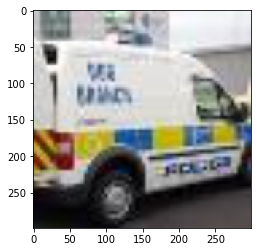

In [13]:
plt.imshow(X_train[0])
plt.show()

In [15]:
pred = model.predict(X_train, batch_size=32)

In [16]:
print(pred)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [20]:
with open('../MicroImageNet/wnids.txt', 'r') as file:
    string = file.read()
strings = string.split('\n')
strings.sort()

['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684'

In [23]:
predi = np.asarray(strings)[np.argmax(pred, axis = 1)]

(10000,)


In [51]:
blah = np.concatenate((files, predi.reshape(-1, 1)), axis = 1)

In [53]:
blah = blah.join

array(['test_830.JPEG', 'n01910747'], dtype=object)

In [56]:
blah = [','.join([f, p]) for (f, p) in blah]

ValueError: too many values to unpack (expected 2)

In [63]:
with open('blah.txt', 'w') as f:
    [f.write(b + '\n') for b in blah]